In [34]:
import pandas as pd

results = pd.read_csv("/Users/tobe2.0/Portfolio/premier league match predictor/data/epl_results_2022-23.csv")
clubs = pd.read_csv("/Users/tobe2.0/Portfolio/premier league match predictor/data/epl_clubs_info_2022-23.csv")

In [35]:
print("results columns:", results.columns.tolist())
print("clubs columns:", clubs.columns.tolist())

results columns: ['Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']
clubs columns: ['club_name', 'abv', 'hex_code', 'logo_link']


In [36]:
# Shape and summary
print("Shape:", results.shape)
print("Columns:", results.columns.tolist())
results.describe()


Shape: (380, 23)
Columns: ['Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']


,FTHG,FTAG,HTHG,HTAG,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
count,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000
mean,1.634211,1.218421,0.757895,0.563158,13.952632,11.310526,4.907895,3.894737,10.597368,10.931579,5.636842,4.471053,1.671053,1.915789,0.047368,0.026316
std,1.419944,1.183518,0.918480,0.746998,5.604170,4.941173,2.495260,2.230627,3.288020,3.463424,3.073370,2.817530,1.249677,1.358357,0.224768,0.160284
min,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,10.000000,8.000000,3.000000,2.000000,8.000000,8.000000,3.000000,2.000000,1.000000,1.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,0.000000,14.000000,11.000000,5.000000,4.000000,10.000000,11.000000,5.000000,4.000000,2.000000,2.000000,0.000000,0.000000
75%,2.000000,2.000000,1.000000,1.000000,17.000000,15.000000,7.000000,5.000000,13.000000,13.000000,8.000000,6.000000,3.000000,3.000000,0.000000,0.000000
max,9.000000,6.000000,5.000000,3.000000,33.000000,30.000000,15.000000,11.000000,23.000000,24.000000,17.000000,19.000000,6.000000,7.000000,2.000000,1.000000


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [38]:
# Encode match result
def encode_result(ftr):
    return {'H': 2, 'D': 1, 'A': 0}.get(ftr, np.nan)

results['result_label'] = results['FTR'].map(encode_result)
results['result_label'].value_counts()

result_label
2    184
0    109
1     87
Name: count, dtype: int64

In [39]:
# Convert 'Date' to datetime
results['Date'] = pd.to_datetime(results['Date'], errors='coerce')

# Extract date features
results['Year'] = results['Date'].dt.year
results['Month'] = results['Date'].dt.month
results['Weekday'] = results['Date'].dt.dayofweek

In [40]:
# Check missing values
missing = results.isnull().sum()
print(missing[missing > 0])

Date       225
Year       225
Month      225
Weekday    225
dtype: int64


In [41]:
results['goal_diff'] = results['FTHG'] - results['FTAG']
results['shots_diff'] = results['HS'] - results['AS']
results['shots_on_target_diff'] = results['HST'] - results['AST']
results['yellow_diff'] = results['HY'] - results['AY']
results['red_diff'] = results['HR'] - results['AR']

In [52]:
# Step 1: Construct long_df with home and away team matches
home = results[['Date', 'HomeTeam', 'FTHG', 'FTAG', 'FTR']].copy()
home['Team'] = home['HomeTeam']
home['Goals_For'] = home['FTHG']
home['Goals_Against'] = home['FTAG']
home['is_home'] = 1

away = results[['Date', 'AwayTeam', 'FTAG', 'FTHG', 'FTR']].copy()
away['Team'] = away['AwayTeam']
away['Goals_For'] = away['FTAG']
away['Goals_Against'] = away['FTHG']
away['is_home'] = 0

long_df = pd.concat([home, away], ignore_index=True)
long_df['Date'] = pd.to_datetime(long_df['Date'])
long_df = long_df.sort_values(by=['Team', 'Date']).reset_index(drop=True)

In [53]:
def get_match_points(row):
    if (row['FTR'] == 'H' and row['is_home']) or (row['FTR'] == 'A' and not row['is_home']):
        return 3
    elif row['FTR'] == 'D':
        return 1
    return 0

long_df['match_points'] = long_df.apply(get_match_points, axis=1)

In [54]:
rolling = long_df.groupby('Team')[['Goals_For', 'Goals_Against', 'match_points']].rolling(window=3).mean().reset_index()

# These rows now have a 'level_1' column that matches long_df's row index
rolling.rename(columns={
    'Goals_For': 'avg_goals_for',
    'Goals_Against': 'avg_goals_against',
    'match_points': 'avg_match_points',
    'level_1': 'row_id'  # rename to match long_df's index
}, inplace=True)

# Merge back on row_id
rolling['row_id'] = rolling['row_id'].astype(int)
long_df = long_df.reset_index().rename(columns={'index': 'row_id'})
long_df = pd.merge(long_df, rolling, on='row_id', how='left')

In [57]:
# Reconstruct Team column if dropped
long_df['Team'] = long_df['HomeTeam'].combine_first(long_df['AwayTeam'])
print(long_df.columns)

Index(['row_id', 'Date', 'HomeTeam', 'FTHG', 'FTAG', 'FTR', 'Team_x',
       'Goals_For', 'Goals_Against', 'is_home', 'AwayTeam', 'match_points',
       'Team_y', 'avg_goals_for', 'avg_goals_against', 'avg_match_points',
       'Team'],
      dtype='object')


In [58]:
# HOME team stats
home_form = long_df[long_df['is_home'] == 1][
    ['Date', 'Team', 'avg_goals_for', 'avg_goals_against', 'avg_match_points']
].rename(columns={
    'Team': 'HomeTeam',
    'avg_goals_for': 'home_avg_goals_for',
    'avg_goals_against': 'home_avg_goals_against',
    'avg_match_points': 'home_avg_points'
})

# AWAY team stats
away_form = long_df[long_df['is_home'] == 0][
    ['Date', 'Team', 'avg_goals_for', 'avg_goals_against', 'avg_match_points']
].rename(columns={
    'Team': 'AwayTeam',
    'avg_goals_for': 'away_avg_goals_for',
    'avg_goals_against': 'away_avg_goals_against',
    'avg_match_points': 'away_avg_points'
})

In [59]:
# Merge home form
results = pd.merge(results, home_form, on=['Date', 'HomeTeam'], how='left')

# Merge away form
results = pd.merge(results, away_form, on=['Date', 'AwayTeam'], how='left')

In [61]:
print(results.columns)


Index(['Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG',
       'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC',
       'AC', 'HY', 'AY', 'HR', 'AR', 'result_label', 'Year', 'Month',
       'Weekday', 'goal_diff', 'shots_diff', 'shots_on_target_diff',
       'yellow_diff', 'red_diff', 'home_avg_goals_for',
       'home_avg_goals_against', 'home_avg_points', 'away_avg_goals_for',
       'away_avg_goals_against', 'away_avg_points'],
      dtype='object')


In [66]:
features = [
    'home_avg_goals_for',
    'home_avg_goals_against',
    'home_avg_points',
    'away_avg_goals_for',
    'away_avg_goals_against',
    'away_avg_points',
    'Month',
    'Weekday'
]

In [67]:
from sklearn.model_selection import train_test_split

X = results[features].dropna()  # drop rows with NaNs
y = results.loc[X.index, 'result_label']  # align target with X

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [68]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Accuracy: 0.67
              precision    recall  f1-score   support

    Away Win       0.70      0.88      0.78         8
        Draw       0.00      0.00      0.00         5
    Home Win       0.73      0.79      0.76        14

    accuracy                           0.67        27
   macro avg       0.48      0.55      0.51        27
weighted avg       0.59      0.67      0.62        27



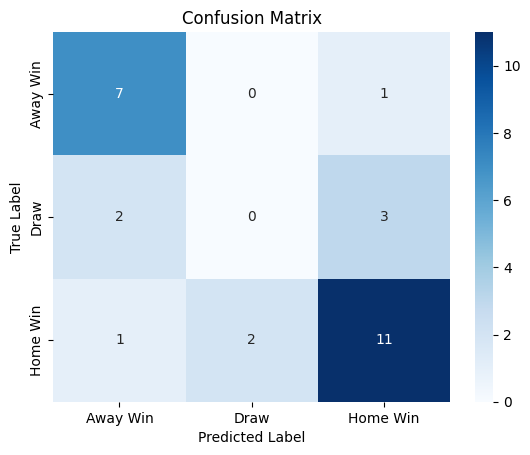

In [69]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = rf_model.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.2f}")

# Classification Report
print(classification_report(y_test, y_pred, target_names=['Away Win', 'Draw', 'Home Win']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Away Win', 'Draw', 'Home Win'],
            yticklabels=['Away Win', 'Draw', 'Home Win'])
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [70]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'  # for multi-class
)

xgb_model.fit(X_train, y_train)

/Users/tobe2.0/Portfolio/venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [01:06:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

XGBoost Accuracy: 0.7777777777777778
              precision    recall  f1-score   support

    Away Win       0.73      1.00      0.84         8
        Draw       0.50      0.60      0.55         5
    Home Win       1.00      0.71      0.83        14

    accuracy                           0.78        27
   macro avg       0.74      0.77      0.74        27
weighted avg       0.83      0.78      0.78        27



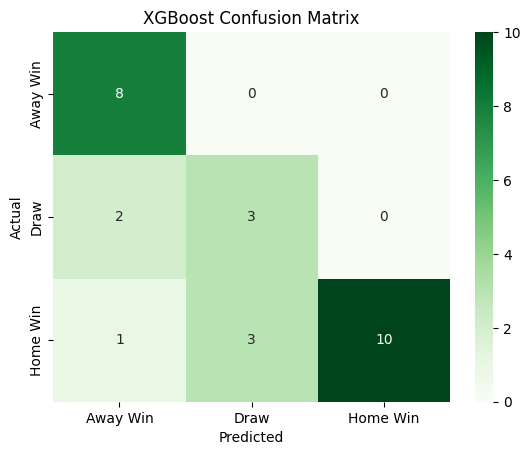

In [71]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = xgb_model.predict(X_test)

# Accuracy
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred))

# Detailed report
print(classification_report(y_test, y_pred, target_names=['Away Win', 'Draw', 'Home Win']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Away Win', 'Draw', 'Home Win'],
            yticklabels=['Away Win', 'Draw', 'Home Win'])
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [72]:
from sklearn.model_selection import cross_val_score

xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

xgb_scores = cross_val_score(xgb, X, y, cv=5)
rf_scores = cross_val_score(rf, X, y, cv=5)

print(f"XGBoost CV Accuracy: {xgb_scores.mean():.3f}")
print(f"Random Forest CV Accuracy: {rf_scores.mean():.3f}")

/Users/tobe2.0/Portfolio/venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [22:51:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/tobe2.0/Portfolio/venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [22:51:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/tobe2.0/Portfolio/venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [22:51:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/tobe2.0/Portfolio/venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [22:51:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_labe

XGBoost CV Accuracy: 0.717
Random Forest CV Accuracy: 0.717


In [75]:
# Extract home and away form features
home_form = results[['Date', 'HomeTeam', 'home_avg_goals_for', 'home_avg_goals_against', 'home_avg_points']].copy()
home_form.columns = ['Date', 'Team', 'avg_goals_for', 'avg_goals_against', 'avg_match_points']

away_form = results[['Date', 'AwayTeam', 'away_avg_goals_for', 'away_avg_goals_against', 'away_avg_points']].copy()
away_form.columns = ['Date', 'Team', 'avg_goals_for', 'avg_goals_against', 'avg_match_points']

# Combine home and away form into one DataFrame
form_df = pd.concat([home_form, away_form])

# Convert to datetime and sort
form_df['Date'] = pd.to_datetime(form_df['Date'])
form_df = form_df.sort_values('Date')

# Get the latest stats for each team
team_form = form_df.groupby('Team').tail(1).reset_index(drop=True)

# Export to CSV
team_form.to_csv("team_form_stats.csv", index=False)
print("✅ team_form_stats.csv created!")

✅ team_form_stats.csv created!
